In [95]:
import pandas as pd
import numpy as np
from numpy import linalg as LA
from matplotlib import pyplot as plt
from datetime import datetime
import copy
from sklearn.decomposition import PCA
import statsmodels.api as sm
from dataclasses import dataclass

In [47]:
df=pd.read_excel("data_int.xlsx")

In [48]:
dd=copy.deepcopy(df)
dd.set_index('Tenor',inplace=True)
Y=dd.diff().dropna()
eig_vals, eig_vectors = LA.eig(252/10000*Y.cov())
eig_vectors[:, 0:3]

array([[ 0.00351033, -0.00972625, -0.00111508],
       [ 0.05665586, -0.16326718,  0.27313784],
       [ 0.10114279, -0.2389149 ,  0.40222423],
       [ 0.11563974, -0.24345609,  0.35581018],
       [ 0.12154093, -0.23509872,  0.27474251],
       [ 0.12568249, -0.22656368,  0.19585028],
       [ 0.12948968, -0.21903235,  0.12500321],
       [ 0.13320457, -0.21206961,  0.0623539 ],
       [ 0.13681963, -0.2051638 ,  0.00709335],
       [ 0.14026214, -0.19791715, -0.04135353],
       [ 0.14344533, -0.19001071, -0.08325192],
       [ 0.1462834 , -0.18118042, -0.11865757],
       [ 0.14870205, -0.17120748, -0.14754572],
       [ 0.15064229, -0.15990426, -0.16990336],
       [ 0.15207044, -0.14712506, -0.18581986],
       [ 0.15298157, -0.13278428, -0.19552188],
       [ 0.15340022, -0.11686787, -0.19936452],
       [ 0.15337685, -0.09943599, -0.19785291],
       [ 0.15297871, -0.08062996, -0.19159875],
       [ 0.15228467, -0.06067689, -0.18129946],
       [ 0.15138052, -0.03988003, -0.167

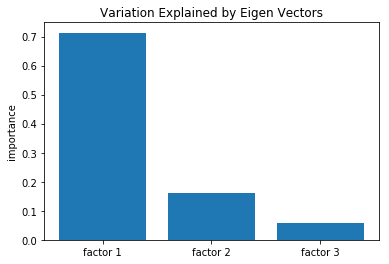

The intuition behind these eigen vectors is 1y,5y and 25 yr rates primarily explain movements in forward curve


In [53]:
eig_vals_importance = []
for i in range(len(eig_vals[0:3])):
    eig_vals_importance.append(eig_vals[i] / sum(eig_vals))
objects = ('factor 1', 'factor 2', 'factor 3') 
y_pos = np.arange(len(objects))
plt.bar(y_pos, eig_vals_importance )
plt.xticks(y_pos, objects)
plt.ylabel('importance')
plt.title('Variation Explained by Eigen Vectors')
plt.show()
print("The intuition behind these eigen vectors is 1y,5y and 25 yr rates primarily explain movements in forward curve")
#plt.plot(eig_vectors[:, 0:3])

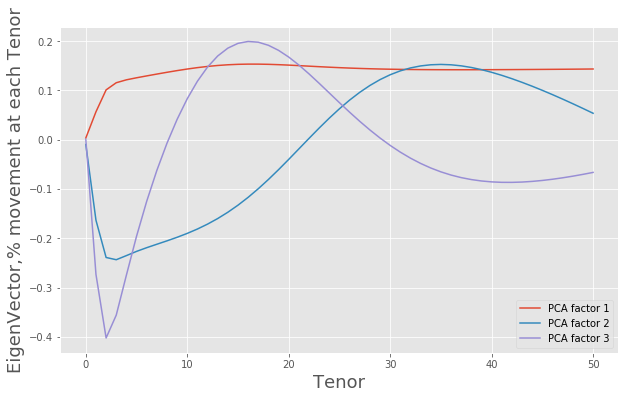

In [59]:
plt.style.use('ggplot')
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 6
plt.xlabel('Tenor', fontsize=18)
plt.ylabel('EigenVector,% movement at each Tenor', fontsize=18)
plt.plot(eig_vectors[:, 0] , label = 'PCA factor 1')
plt.plot(eig_vectors[:, 1], label = 'PCA factor 2')
plt.plot(-1*eig_vectors[:, 2], label = 'PCA factor 3')
plt.grid = True
plt.legend()

# Volatility functions are calculated by sqrt(lambda_i)*e(i) -- this is equivalent to one standard deviation move in e(i) direction.

In [73]:
Vol_1 = list(np.sqrt(eig_vals[0])*eig_vectors[:,0])
Vol_2 = list(np.sqrt(eig_vals[1])*eig_vectors[:,1])
Vol_3 = list(np.sqrt(eig_vals[2])*eig_vectors[:,2])
ff={'Vol_1':Vol_1,'Vol_2':Vol_2,'Vol_3':Vol_3}

In [74]:
Vol_Function = pd.DataFrame(ff)
Vol_Function['Tenor']=df.columns[1:]

# Regression Equation Vol_1 = b_0
## For this volatility function, a straight line provides a reasonable and simple fit.We know that the PC1 attribution is the parallel shift of a whole curve.

1st Volatility Component, Vol_1


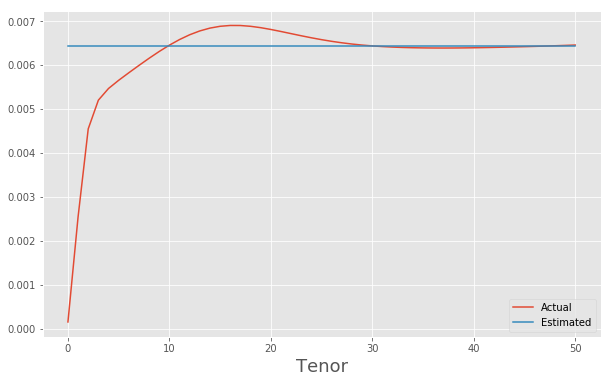

In [92]:
b_0 = np.median(Vol_Function['Vol_1'])
fig_size[0] = 10
fig_size[1] = 6
plt.xlabel('Tenor', fontsize=18)
plt.plot(Vol_Function['Vol_1'],label='Actual')
plt.plot([b_0]*len(Vol_1),label='Estimated')
plt.grid = True
plt.legend()
print("1st Volatility Component, Vol_1")

# Regression Equation - Vol_2=b0+b1*tau+b2*tau^2+b3*tau^3
## Note: we use regression for fitting -- not testing whether volatility is a function of time

In [145]:
lhs=Vol_Function['Vol_2']
predictors={'b_1*tau':list(Vol_Function['Tenor']),'b_2*tau^2':list(map(lambda x: x**2,list(Vol_Function['Tenor']))),'b_3*tau^3':list(map(lambda x: x**3,list(Vol_Function['Tenor'])))}
rhs=pd.DataFrame(predictors)
rhs=sm.add_constant(rhs)
res2 = sm.OLS(lhs, rhs, missing='drop').fit()
res2.params

const       -0.003568
b_1*tau     -0.000563
b_2*tau^2    0.000118
b_3*tau^3   -0.000004
dtype: float64

In [146]:
res2.rsquared

0.9487379690949697

2nd Volatility Component, Vol_2


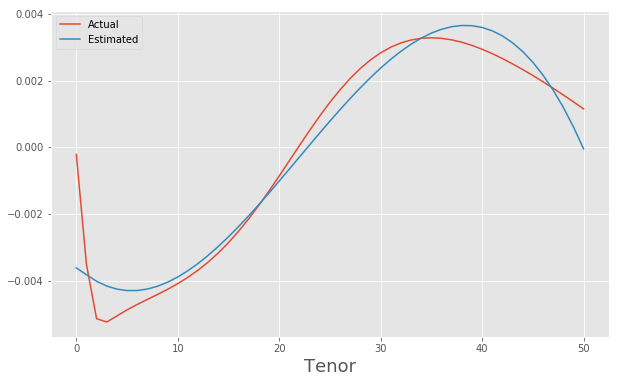

In [147]:
fig_size[0] = 10
fig_size[1] = 6
plt.xlabel('Tenor', fontsize=18)
plt.plot(Vol_Function['Vol_2'],label='Actual')
plt.plot(res2.predict(rhs),label='Estimated')
plt.grid = True
plt.legend()
print("2nd Volatility Component, Vol_2")

# Regression Equation - Vol_3=b0+b1*tau+b2*tau^2+b3*tau^3


In [148]:
lhs=Vol_Function['Vol_3']
predictors={'b_1*tau':list(Vol_Function['Tenor']),'b_2*tau^2':list(map(lambda x: x**2,list(Vol_Function['Tenor']))),'b_3*tau^3':list(map(lambda x: x**3,list(Vol_Function['Tenor'])))}
rhs=pd.DataFrame(predictors)
rhs=sm.add_constant(rhs)
res3 = sm.OLS(lhs, rhs, missing='drop').fit()
res3.params

const        0.004824
b_1*tau     -0.001780
b_2*tau^2    0.000144
b_3*tau^3   -0.000003
dtype: float64

In [149]:
res3.rsquared

0.7438333100590271

2nd Volatility Component, Vol_2


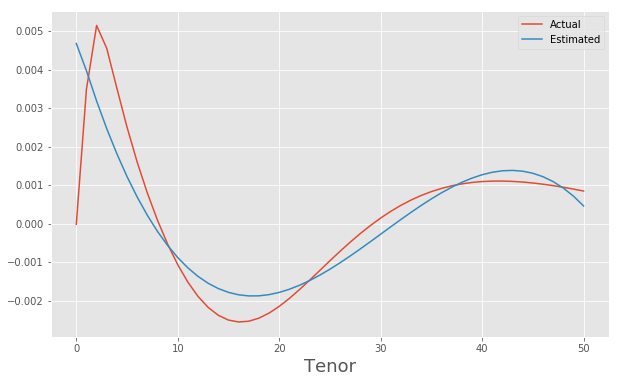

In [150]:
fig_size[0] = 10
fig_size[1] = 6
plt.xlabel('Tenor', fontsize=18)
plt.plot(Vol_Function['Vol_3'],label='Actual')
plt.plot(res3.predict(rhs),label='Estimated')
plt.grid = True
plt.legend()
print("2nd Volatility Component, Vol_2")

In [156]:
def Volfactor_1(Tau):
    return np.median(Vol_1)

def Volfactor_2(Tau):
    return res2.params[0]+res2.params[1]*Tau+res2.params[2]*Tau**2+res2.params[3]*Tau**3

def Volfactor_3(Tau):
    return res3.params[0]+res3.params[1]*Tau+res3.params[2]*Tau**2+res3.params[3]*Tau**3
def drift(T):
    Tau=T
    if Tau == 0:
        M = 0
    else:
        dTau = 0.01                                     
        N = int(Tau / dTau)
        dTau = Tau / N     
        
    M1 = 0.5 * Volfactor_1(0)
    M2 = 0.5 * Volfactor_2(0)
    M3 = 0.5 * Volfactor_3(0)
    for i in range(1,N):
        M1 = M1 + Volfactor_1(i * dTau) 
        M2 = M2 + Volfactor_2(i * dTau)
        M3 = M3 + Volfactor_3(i * dTau)
    
    M1 = M1 + 0.5 * Volfactor_1(Tau)
    M1 = M1 * dTau
    M1 = Volfactor_1(Tau) * M1
    M2 = M2 + 0.5 * Volfactor_2(Tau)
    M2 = M2 * dTau
    M2 = Volfactor_2(Tau) * M2
    M3 = M3 + 0.5 * Volfactor_3(Tau)
    M3 = M3 * dTau
    M3 = Volfactor_3(Tau) * M3
    
    return M1+M2+M3

In [160]:
params={'Tenor':list(Vol_Function['Tenor']),'Drift':[drift(i) for i in ]}
forward_rate_params = pd.DataFrame()

0.0001283457958836278

In [166]:
x=list(Vol_Function['Tenor']).insert(0,0)

In [168]:
x